import packages

In [83]:
import torch
import torchvision
import torchvision.transforms as transforms
from osgeo import gdal_array
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
 
from torch import nn
from torch.nn import functional as F
 

In [84]:
!pip install segmentation-models-pytorch==0.1.0
 

In [85]:
import segmentation_models_pytorch as smp

In [86]:
size = 128
bs = 16 #batchsize
num_class= 15

Used to crop the imput images

In [87]:
def slice (arr, size, inputsize,stride):
    result = []
    if stride is None:
        stride = size
    for i in range(0, (inputsize-size)+1, stride):
        for j in range(0, (inputsize-size)+1, stride):
        
            if arr.ndim == 3:
                s = arr[:,i:(i+size),j:(j+size), ]
            else:
                s = arr[i:(i+size),j:(j+size), ]
            result.append(s)
 
 
    result = np.array(result)
    return result

def batchslice (arr, size, inputsize, stride, num_img):
    result = []
    for i in range(0, num_img):
        s= slice(arr[i,], size, inputsize, stride )
        result.append(s )
    result = np.array(result)
    result = result.reshape(result.shape[0]*result.shape[1], result.shape[2], result.shape[3], -1)
    return result


load the different tiles into 1 variable

In [88]:
reduce = 16
#stack all files into 1 variable
def load_raster(path,data):
    files = []
    for file in glob.glob(path+data+'*.tif'):
        file1 = gdal_array.LoadFile(file)
        #only use 50% of the points to reduce memory
        if np.ndim(file1)==3:
            file1=file1[:,::reduce,::reduce]
        else:
            file1=file1[::reduce,::reduce]
        files.append(file1)
    stacked = np.array(files)
    return stacked

def load_data(path,data1,data2):
    part1 = load_raster(path,data1)
    part2 = load_raster(path,data2)
    print(part1.shape,part2.shape)
    if np.ndim(part1)< np.ndim(part2):#check if dimmensions are equal
        part1 = np.expand_dims(part1,axis=1)
    elif np.ndim(part1)> np.ndim(part2):
        part2 = np.expand_dims(part2,axis=1)
    print(part1.shape,part2.shape)
    total = np.concatenate((part1,part2),axis=1)
    return total
'new input'



'new input'

Slice input data into smaller size images

In [89]:
training= load_data("../input/guided-research/Training/","DEM","Wadden")
validation = load_data("../input/guided-research/Validation/","DEM","Wadden")
y_train= load_raster("../input/guided-research/Training/","class")
y_val= load_raster("../input/guided-research/Validation/","class")


(2, 1000, 1000) (2, 3, 1000, 1000)
(2, 1, 1000, 1000) (2, 3, 1000, 1000)
(2, 1000, 1000) (2, 3, 1000, 1000)
(2, 1, 1000, 1000) (2, 3, 1000, 1000)


In [90]:


training  = batchslice(training,size,training[0].shape[1],size,training.shape[0])
validation=batchslice(validation,size,validation[0].shape[1],size,validation.shape[0])

y_train = batchslice(y_train,size,y_train[0].shape[1],size,y_train.shape[0]).squeeze()
y_val = batchslice(y_val,size,y_val[0].shape[1],size,y_val.shape[0]).squeeze()
  

print(training.shape,validation.shape,y_train.shape, y_val.shape)


(98, 4, 128, 128) (98, 4, 128, 128) (98, 128, 128) (98, 128, 128)


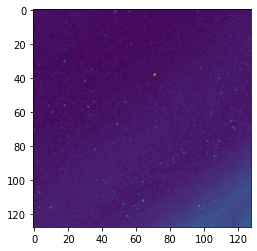

15

In [91]:
plt.imshow(training[50,2,:,:])
plt.show() 
np.amax(y_val)

In [92]:
def class2dim (mask, num_class):
    
    new_mask = np.reshape(np.tile(mask, num_class), ( mask.shape[0], mask.shape[1],mask.shape[2], num_class))
 
    for j in range(mask.shape[0]):
         aslice = new_mask[j,]
         amask = mask[j,]
         for i in range(num_class):
             aslice[:,:,i] = np.multiply(amask == i+1,1)        
         new_mask[j,]=aslice
    return new_mask
      

In [93]:
new_mask = class2dim(y_train, num_class)
new_mas_val = class2dim(y_val, num_class)

15 1


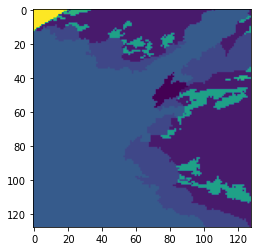

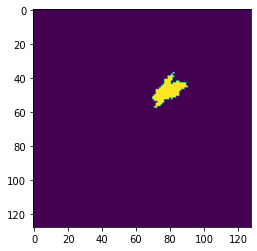

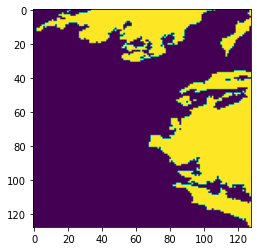

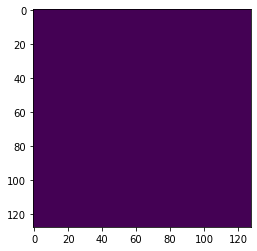

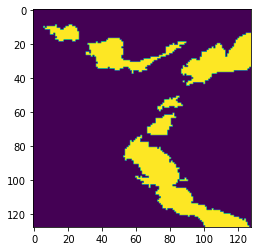

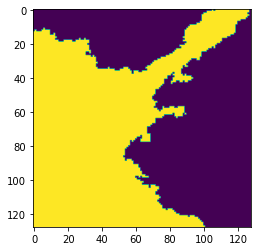

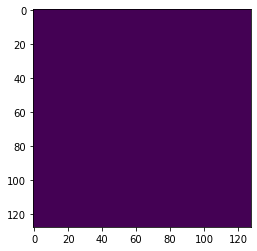

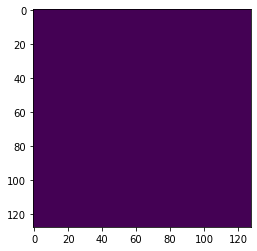

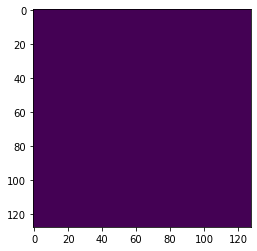

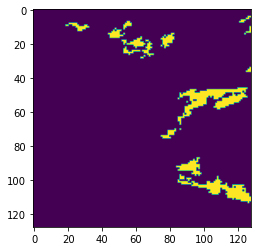

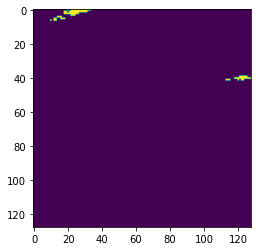

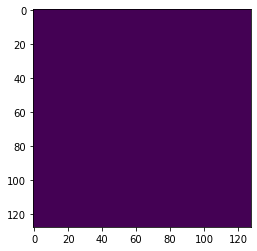

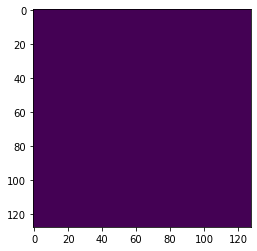

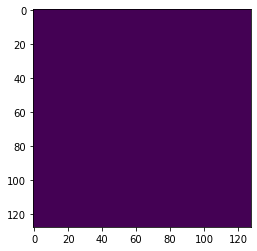

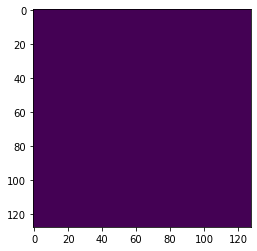

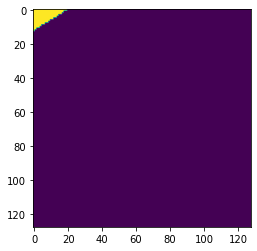

In [94]:
#check
whichone =  30
print(np.amax(y_train[whichone,] ),np.amin(y_train[whichone,] ))
plt.imshow(y_train[whichone,] )
plt.show() 
for n in range(num_class):
    plt.imshow(new_mask[whichone,:,:,n])
    plt.show() 


Code used to see slicing result

training = list(zip(training[:,1,:,:], y_train))
validation = list(zip(validation[:,1,:,:], y_val))m
 

In [95]:
new_mask =  np.moveaxis(new_mask, -1, 1)
new_mas_val = np.moveaxis(new_mas_val, -1, 1)

In [97]:
from torch.utils.data import DataLoader, TensorDataset 
def myloader(trainX, trainY, valX,valY):
    train = TensorDataset(torch.Tensor(trainX[:,:,:,:]), torch.Tensor(trainY )) # create your datset
    train  = DataLoader(train, batch_size=bs) # create your dataloader
    
    vali= TensorDataset(torch.Tensor(valX[:,:,:,:]),torch.Tensor(valY  )) # create your datset
    vali = DataLoader(vali, batch_size=bs) # create your dataloader
    return train , vali 


In [98]:
#np.save("../wadden1", zip(training, new_mask, validation, new_mas_val))

Get torch loader, got the error in catalyst with "collection dont have attribute size", use original array as demonstrated in catalyst

In [99]:
train_loader, valid_loader = myloader(training, new_mask, validation, new_mas_val)
 # torch.LongTensor() for some losses

In [100]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = [format(x, '2d') for x in range(1,16)]
 
print(len(CLASSES))
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
#model = smp.FPN(
#    encoder_name=ENCODER, 
#    encoder_weights=ENCODER_WEIGHTS, 
#    classes=len(CLASSES), 
#    activation=ACTIVATION,
#)
model = smp.Unet(classes=len(CLASSES), in_channels=4)
 
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

#loss = smp.utils.losses.DiceLoss()
loss=nn.BCEWithLogitsLoss()
#loss = nn.BCELoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)
max_score = 0

for i in range(0, 4):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, 'best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

15


RuntimeError: CUDA error: device-side assert triggered

In [ ]:
print(model)

In [ ]:
#comparison = training == validation
#equal_arrays = comparison.all()
#print(equal_arrays)
#inputs, masks = next(iter(loaders['valid']))
 

Pre-trained Unet segmentation model

In [ ]:
class myLoss(torch.nn.Module):

    def __init__(self, pos_weight=1):
      super().__init__()
      self.pos_weight = pos_weight

    def forward(self, input, target):
      epsilon = 10 ** -44
      input = input.sigmoid().clamp(epsilon, 1 - epsilon)

      my_bce_loss = -1 * (self.pos_weight * target * torch.log(input)
                          + (1 - target) * torch.log(1 - input))
      add_loss = (target - 0.5) ** 2 * 4
      mean_loss = (my_bce_loss * add_loss).mean()
      return mean_loss

    
def SegLossFn(predictions,targets):
    _, c, _, _ = predictions.size()
    loss=0
    m=nn.Sigmoid()
    loss_fn=nn.BCELoss()
    #BCE-> MCE by adding for each of the classes BCE
    for i in range(c):
        loss+=loss_fn(m(predictions[0][i]),Variable(targets[i][0]).cuda())
            
    return loss
# for keras
class dice (torch.nn.Module):
    def __init__(self, pos_weight=1):
      super().__init__()
      self.pos_weight = pos_weight
    
    def dice_coef_9cat(y_true, y_pred, smooth=1e-7):
        '''
        Dice coefficient for 10 categories. Ignores background pixel label 0
        Pass to model as metric during compile statement
        '''
        y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=10)[...,1:])
        y_pred_f = K.flatten(y_pred[...,1:])
        intersect = K.sum(y_true_f * y_pred_f, axis=-1)
        denom = K.sum(y_true_f + y_pred_f, axis=-1)
        return K.mean((2. * intersect / (denom + smooth)))

 
    def forward(y_true, y_pred, smooth=1e-7):
        y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=10)[...,1:])
        y_pred_f = K.flatten(y_pred[...,1:])
        intersect = K.sum(y_true_f * y_pred_f, axis=-1)
        denom = K.sum(y_true_f + y_pred_f, axis=-1)
        return 1-K.mean((2. * intersect / (denom + smooth)))


In [ ]:
from catalyst.dl import utils
import collections
  
import torchvision.transforms as transforms

open_fn = lambda x: {"features": x[0], "targets": x[1]}

train_loader = utils.get_loader(
    list(zip(training.astype(np.float32), new_mask.astype(np.float32))), 
    open_fn=open_fn,  
    batch_size=bs, 
    num_workers=4, 
    shuffle=True)

valid_loader = utils.get_loader(
    list(zip(validation.astype(np.float32), new_mas_val.astype(np.float32))), 
    open_fn=open_fn,  
    batch_size=bs, 
    num_workers=4, 
    shuffle=False)

 
from catalyst.dl import utils
 
loaders = collections.OrderedDict()


loaders["train"] = train_loader
loaders["valid"] =valid_loader

%load_ext tensorboard
%tensorboard --logdir {logdir}

In [ ]:
from catalyst.contrib.nn import DiceLoss, IoULoss
from catalyst.dl.callbacks import DiceCallback, IouCallback, \
  CriterionCallback, MetricAggregationCallback
# we have multiple criterions
criterion = {
    "dice": DiceLoss(),
    "iou": IoULoss(),
    "bce": nn.BCEWithLogitsLoss()
}


callbacks = [
    # Each criterion is calculated separately.
    CriterionCallback(
        input_key="mask",
        prefix="loss_dice",
        criterion_key="dice"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_iou",
        criterion_key="iou"
    ),
    CriterionCallback(
        input_key="mask",
        prefix="loss_bce",
        criterion_key="bce"
    ),

    # And only then we aggregate everything into one loss.
    MetricAggregationCallback(
        prefix="loss",
        mode="weighted_sum", # can be "sum", "weighted_sum" or "mean"
        # because we want weighted sum, we need to add scale for each loss
        metrics={"loss_dice": 1.0, "loss_iou": 1.0, "loss_bce": 0.8},
    ),

    # metrics
    DiceCallback(input_key="mask"),
    IouCallback(input_key="mask"),
]

 

In [ ]:
from catalyst.contrib.models.cv import Unet,ResnetUnet
from catalyst.contrib.nn import DiceLoss, IoULoss, NLLLoss

from catalyst.dl import SupervisedRunner

# experiment setup
num_epochs =3
logdir = "../segmentation_notebook"

# model, criterion, optimizer
#model =  torchvision.models.segmentation.fcn_resnet50(pretrained=False, progress=True, num_classes=num_class)
model =Unet(num_classes=num_class, in_channels=4, num_channels=64, num_blocks=4)# catalyst Unet
#model = ResnetUnet(num_classes=num_class) # can only take 3 channels 
#model = smp.Unet(classes=num_class, in_channels=4)
 
criterion =smp.utils.losses.DiceLoss()
#nn.BCEWithLogitsLoss()
#myLoss()
#nn.BCEWithLogitsLoss() # this and myLoss() can run but gradient does not descent. 
# nn.CrossEntropyLoss()  # the type should be Long
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20, 40], gamma=0.3)


# model runner
runner = SupervisedRunner()

# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    #callbacks=callbacks,
    logdir=logdir,
    num_epochs=num_epochs,
    verbose=True,
    #main_metric=smp.utils.metrics.IoU(threshold=0.5),
  
    load_best_on_end=True,
)
 

In [ ]:
import inspect
inspect.signature(spm.Unet)

In [ ]:
runner_out = runner.predict_loader(loader=loaders["valid"])

In [ ]:
import math 

sigmoid = lambda x: 1/(1 + np.exp(-x))
for i, output in enumerate (runner_out):
    threshold = 0.5
    output = sigmoid( output["logits"].cpu)
    output = (output > threshold).astype(np.uint8)
    print(output.shape)
    plt.imshow(output)

In [ ]:
plt.style.use("ggplot")
%matplotlib inline

sigmoid = lambda x: 1/(1 + np.exp(-x))

for i, (input, output) in enumerate(zip(validation, runner_out)):
    image, mask = input
    
    threshold = 0.5
    
    plt.figure(figsize=(10,8))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image, 'gray')
    
    plt.subplot(1, 3, 2)
    output = sigmoid(output["logits"].copy())
    output = (output > threshold).astype(np.uint8)
    plt.imshow(output, "gray")
    
    plt.subplot(1, 3, 3)
    plt.imshow(mask, "gray")
    
    plt.show()